In [2]:
# %% IMPORTS
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import pygimli           as pg
import pygimli.meshtools as mt
import cmasher           as cmr
import functools
import warnings

from pygimli.viewer             import pv
from pygimli.physics            import ert
from scipy.interpolate          import griddata
from AZ_pygimli_3DTopo          import *
from PlotFunctions_Ch5          import *
from datetime                   import datetime
from JointEntropyClass          import JointEntropyInversion as JEI

warnings.filterwarnings("ignore")

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert
from pygimli.viewer import pv

import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.viewer import pv
from pygimli.physics.gravimetry import GravityModelling

path = 'C:/Users/anton.ziegon/Documents/GitHubRepos/Joint-Minimum-Entropy-Inversion-Paper/'

fn_dir  = path+'Data/Synthetic3D/'

## Create ERT Data Container and Mesh

In [3]:
# Model dimensions
dx = 1
x = np.arange(0., 51, dx)
y = np.arange(0., 51, dx)
z = np.arange(0., 21, dx)

In [4]:
######################################################
# 2D SLM scheme
scheme = ert.createData(elecs=x[1:-1],schemeName='slm')


# Add electrode coordinates of 3 lines
sensor_list = []
#  Line 1
for idx in np.arange(scheme.sensorCount()):
    sensor_list.append([x[1:-1][idx],25,0]) 
sensor_list=np.array(sensor_list)
scheme.setSensors(sensor_list)
print(scheme)

# Correct geometric factors for 3D
scheme["k"] = ert.geometricFactors(scheme, dim=3)



##############################################################
# For three intersectiing lines
# # 2D SLM scheme
# scheme = ert.createData(elecs=x[1:-1],schemeName='slm')
# print(scheme)

# # tripple the scheme to simulate 3 ERT lines in 3D
# length = len(scheme['a'])
# a_arr = np.zeros(length*3); b_arr = np.zeros(length*3); m_arr = np.zeros(length*3); n_arr = np.zeros(length*3); k_arr = np.zeros(length*3); valid_arr = np.zeros(length*3)

# a_arr[:length] = scheme['a']; a_arr[length:length*2] = scheme['a']+scheme.sensorCount(); a_arr[length*2:length*3] = scheme['a']+2*scheme.sensorCount();
# b_arr[:length] = scheme['b']; b_arr[length:length*2] = scheme['b']+scheme.sensorCount(); b_arr[length*2:length*3] = scheme['b']+2*scheme.sensorCount();
# m_arr[:length] = scheme['m'];m_arr[length:length*2] = scheme['m']+scheme.sensorCount(); m_arr[length*2:length*3] = scheme['m']+2*scheme.sensorCount();
# n_arr[:length] = scheme['n']; n_arr[length:length*2] = scheme['n']+scheme.sensorCount(); n_arr[length*2:length*3] = scheme['n']+2*scheme.sensorCount();
# n_arr[:length] = scheme['k']; k_arr[length:length*2] = scheme['k']; k_arr[length*2:length*3] = scheme['k'];
# valid_arr[:length] = scheme['valid']; valid_arr[length:length*2] = scheme['valid']; valid_arr[length*2:length*3] = scheme['valid'];
# scheme['a']=a_arr;scheme['b']=b_arr;scheme['m']=m_arr;scheme['n']=n_arr;scheme['k']=k_arr;scheme['valid']=valid_arr;
# print(scheme)

# # Add electrode coordinates of 3 lines
# sensor_list = []
# #  Line 1
# for idx in np.arange(scheme.sensorCount()):
#     sensor_list.append([x[1:-1][idx],20,0]) 
# #  Line 2
# for idx in np.arange(scheme.sensorCount()):
#     sensor_list.append([x[1:-1][idx],30,0]) 
# #  Line 3
# for idx in np.arange(scheme.sensorCount()):
#     sensor_list.append([25,y[1:-1][idx],0]) 
# sensor_list=np.array(sensor_list)
# scheme.setSensors(sensor_list)
# assert scheme.sensorCount() == 3*49
# print(scheme)

# # Correct geometric factors for 3D
# scheme["k"] = ert.geometricFactors(scheme, dim=3)

Data: Sensors: 49 data: 552, nonzero entries: ['a', 'b', 'k', 'm', 'n', 'valid']


In [7]:
##############################################
# Create Inversion mesh
plc = mt.createCube(size=[x.max(), y.max(), z.max()],pos=[x.max()*0.5, y.max()*0.5, z.max()*0.5], boundaryMarker=1)
for s in scheme.sensors():
    plc.createNode(s)
    plc.createNode(s + [0, 0, -0.2])
mesh_inv = mt.createMesh(plc, area=10)
mesh_inv["CM"]=np.array(mesh_inv.cellMarkers())
mesh_inv['CID']=np.array([c.id() for c in mesh_inv.cells()])
mesh_inv.save(fn_dir+'mesh_ert')



####################################################
# Create FWD Polygon
diatreme = mt.createCube(size=[11, 11, 15], pos=[x.max()*0.5, y.max()*0.5, 5+7.5], marker=2)
plc += diatreme



####################################################
# Create FWD mesh
mesh = mt.createMesh(plc, area=10)
mesh["CM"]=np.array(mesh.cellMarkers())
mesh['CID']=np.array([c.id() for c in mesh.cells()])
sus = [0.1 if c==2 else 0 for c in mesh.cellMarkers()]
res = [40 if c==2 else 400 for c in mesh.cellMarkers()]
mesh['sus'] = np.array(sus) #susceptibility contrast
mesh['res'] = np.array(res) #susceptibility contrast

showModels=False
if showModels==True:
    pg.show(mesh_inv, showMesh=True,alpha=.30)
    pg.show(plc, showMesh=True,alpha=.30)
    pg.show(mesh, showMesh=True,alpha=.30)

mesh.save(fn_dir+'mesh-fwd')
mesh_inv.save(fn_dir+'mesh-inv')

1

## Magnetics Data Generation

In [18]:
F, I, D = 50000, 75, 25  # total field in nT
H = F * np.cos(np.deg2rad(I))
X = H * np.cos(np.deg2rad(D))
Y = H * np.sin(np.deg2rad(D))
Z = F * np.sin(np.deg2rad(I))
igrf = [D, I, H, X, Y, Z, F]

py, px = np.meshgrid(x[2:-2:2], y[2:-2:2])
px = px.ravel()
py = py.ravel()
points = np.column_stack((px, py, np.ones_like(px)*1))

# The forward operator
cmp = ["TFA"]  # ["Bx", "By", "Bz"]
fop = MagneticsModelling(mesh=mesh, points=points, cmp=cmp, igrf=igrf)
data = fop.response(mesh["sus"])


   0%|          |0/576 [00:00 < ?]

Text(0.5, 1.0, 'TFA\nnT')

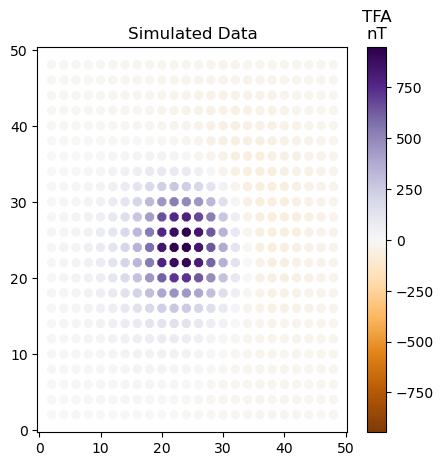

In [19]:
absError = np.abs(data) * 0.02 + 1
data += np.random.randn(len(data)) * absError

# Show data
fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
ax.set_title('Simulated Data')
mm = np.max(np.abs(data))
im0 = ax.scatter(points[:,0], points[:,1], c=data, marker='8', cmap="PuOr", vmin=-mm, vmax=mm)
cb1 = fig.colorbar(im0, ax=ax, orientation='vertical')
cb1.ax.set_title('TFA\nnT')

In [20]:
np.save(fn_dir+'mag_data', data)
np.save(fn_dir+'mag_sensors', points)

## ERT

In [21]:
rhomap = [[1,40], [2,400]]
ert_data = ert.simulate(mesh, res=rhomap, scheme=scheme, debug=True, seed=420)

RuntimeError: ./core/src/matrix.h:466		GIMLI::Vector<ValueType2>& GIMLI::Matrix<ValueType>::rowRef(GIMLI::Index) [with ValueType = double; GIMLI::Index = long long unsigned int]  48 <= 48